In [83]:
import pandas as pd
import numpy as np
import random
random.seed(500)
np.random.seed(500)
import matplotlib.pyplot as plt


In [84]:
def check_bounds(ind):
    return  ind>=0 and ind<75

In [85]:
def split_to_states(agent_list):
    list_s, list_i, list_r = [],[],[]
    for agent in agent_list:
        if agent.state == "S": list_s.append(agent)
        elif agent.state=="I": list_i.append(agent)
        elif agent.state == "R": list_r.append(agent)
    return list_s, list_i, list_r

In [86]:
import re
def plot_func(df_orig, title = ""):
    df = df_orig.copy()
    ax = df.plot(x="Time",
                  y=["Susceptible","Infected","Recovered"], 
                  color=["blue","red","green"],
                  figsize = (4,4))
    ax.set_xlabel("Time")
    ax.set_ylabel("Population Ratio")
    plt.title(title)
    plt.savefig(f"{title}.png")

# Part A and Part B
- A. Building the Base Model: Infection Dynamics in a Population
- B. Extending the Model: Social Distancing and Intervention Strategies

- The agent environment class was first used for base model, and later extendws to account for social distancing

In [88]:
class Agent_Environment:
    def __init__(self, x_size, y_size,  p=0.5, q = 0.5, direction_choice_p = [], social_distancing=False):
        self.grid = [[[] for _ in range(x_size)] for _ in range(y_size)]
        self.num_s = 0 
        self.num_i = 0
        self.num_r = 0
        self.p = p
        self.q = q
        self.all_agents = []
        self._get_all_agents()
        self.direction_choice_p = direction_choice_p

    # If social distancing is True
    # 1. reduced probability of moving at each step -> high probability of choosing "same" in possible directions list of [up, left, down, right,same] : (p(same) = 0.8 )
    # 2. agents actively move away from cells with infected individuals when possible -> reduce probability p that the susceptible agent becomes infected (default p = 0.1)
        if not self.direction_choice_p:
            if social_distancing: 
                self.direction_choice_p = [0.05, 0.05, 0.05, 0.05, 0.8] # correspoding to [up, left, down, right,same]
                self.p = 0.1 # reduce probability p that the susceptible agent becomes infected
            else:
                self.direction_choice_p=[0.22, 0.22, 0.22, 0.22, 0.12] # higher frequency of moving instead of stay
        


    def _get_all_agents(self):
        self.all_agents = []
        for y_list in self.grid:
            for agents_list in y_list:
                for agent in agents_list:
                    self.all_agents.append(agent)
        
    def move_time_step(self, print_out=False):
        self.move_all_agents()
        self.update_transmission_recovery()
        assert len(self.all_agents) == (self.num_s+self.num_i + self.num_r)
        return self.get_stats(print_out)
    
    def get_stats(self, print_out=False):
        if print_out:
            print("Susceptible:", self.num_s)
            print("Infected:", self.num_i)
            print("Recovered:", self.num_r)
        return (self.num_s, self.num_i, self.num_r)
    
    def move_all_agents(self):
        # move all agents with random probability
        all_agents = list(self.all_agents)
        for agent in all_agents:
            agent.move()
        assert len(self.all_agents)==100

        
    def update_transmission_recovery(self):
        # update grid based on transmission and recovery
        for y_list in self.grid:
            for agents_list in y_list:
                list_s, list_i, list_r = split_to_states(agents_list)
                # if there are infectious agents
                if list_i:
                    # update S states with p probability
                    for s_agent in list_s:
                        s_agent.state = np.random.choice(["S", "I"], p=[1 - self.p, self.p])
                        if s_agent.state == "I":
                            self.num_i+=1
                            self.num_s-=1
                    # update infectious based on q to recover
                    for i_agent in list_i:
                        i_agent.state = np.random.choice(["I", "R"], p = [1-self.q, self.q])
                        if i_agent.state == "R":
                            self.num_r+=1
                            self.num_i-=1
    def print_grid(self):
        for y_list in self.grid:
            for agents_list in y_list:
                if not agents_list: print("000000", end="")
                else:
                    list_s, list_i, list_r = split_to_states(agents_list)
                    print(f"S{len(list_s)}I{len(list_i)}R{len(list_r)}", end="")
            print()


class Agent:
    _id_counter = 0
    def __init__(self, state, agent_env):
        self.state = state
        self.grid_x = -1
        self.grid_y = -1
        self.agent_env = agent_env
        self.id = Agent._id_counter
        Agent._id_counter+=1        

    def move(self):
        directions = ["up", "down", "left", "right", "same"]
        chosen_direction =  np.random.choice(directions, p = self.agent_env.direction_choice_p)
        new_x, new_y = self.grid_x, self.grid_y

        if chosen_direction=="up":
            if check_bounds(self.grid_y-1): new_y = self.grid_y-1
        elif chosen_direction =="down":
            if check_bounds(self.grid_y+1):new_y = self.grid_y +1
        elif chosen_direction=="left":
            if check_bounds(self.grid_x-1): new_x = self.grid_x-1
        elif chosen_direction =="right":
            if check_bounds(self.grid_x+1):new_x = self.grid_x+1
        # print(new_x, new_y, self.grid_x, self.grid_y)
        if (new_x, new_y)!= (self.grid_x, self.grid_y):
            # remove from the current grid position
            self.agent_env.grid[self.grid_y][self.grid_x].remove(self)
            # move to new grid position
            curr_agent_list =  self.agent_env.grid[new_y][ new_x]
            if self not in curr_agent_list:
                self.agent_env.grid[new_y][ new_x].append(self)
                self.grid_x  = new_x
                self.grid_y = new_y
    def add_to_grid(self, grid_x, grid_y):
        curr_agent_list =  self.agent_env.grid[grid_y][ grid_x]
        if self not in curr_agent_list:
            self.agent_env.grid[grid_y][ grid_x].append(self)
            self.grid_x  = grid_x
            self.grid_y = grid_y
            self.agent_env.num_s += self.state =="S"
            self.agent_env.num_r += self.state =="R"
            self.agent_env.num_i += self.state =="I"
            self.agent_env._get_all_agents()

    def __repr__(self): 
        return f"ID: {self.id}, State: {self.state}, Coordinates {self.grid_x, self.grid_y}"

In [89]:
def create_populate_grid(agent_env):
    susceptible_agents = [ Agent("S", agent_env) for i in range(95)]
    infected_agents = [Agent("I", agent_env) for i in range(5)]
    all_agents = susceptible_agents + infected_agents

    grid_coordinates = [(x,y )for x in range(75) for y in range(75)]
    random_indices = random.sample(grid_coordinates, 100)
    for i in range(100):
        rand_x, rand_y = random_indices[i][0], random_indices[i][1]
        all_agents[i].add_to_grid(rand_x, rand_y)
def simulate_time_steps(agent_env, step_size = 200):
    results_list = []
    for i in range(step_size):
        res = agent_env.move_time_step(print_out=False)
        results_list.append(res)
    return results_list

In [90]:
def run_trial(p, q, social_distancing=False, direction_choice_p =[], show_plot=True, title = "", ):

    agent_env = Agent_Environment( x_size=75, y_size=75,  p=p, q=q, social_distancing=social_distancing,
                                  direction_choice_p=direction_choice_p)
    create_populate_grid(agent_env)
    results_list = simulate_time_steps(agent_env)
    df = pd.DataFrame(results_list, columns=["Susceptible", "Infected", "Recovered"])
    df["Time"] = df.index
    if show_plot:
        title+= "Base model" if not social_distancing else "Social Distancing"
        title += f" p:{p}, q:{q}"
        if direction_choice_p:title= f"p_{p}, q_{q}" " Movement-prob_" + str(direction_choice_p[-1])
        plot_func(df, title)
    return df

### iii. Run the Simulation ,  IV Sensitivity Analysis

#### No social distancing

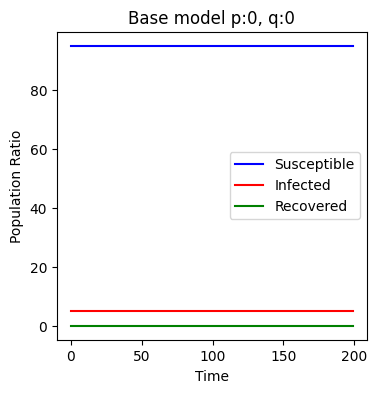

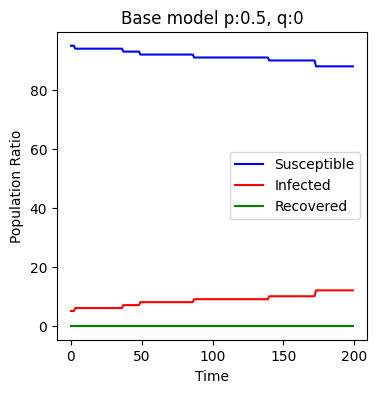

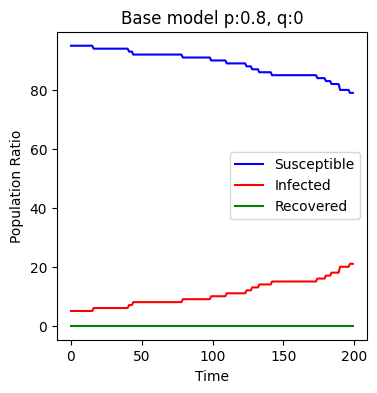

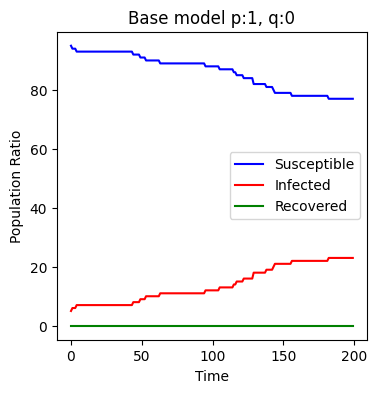

In [91]:
# No social distancing
run_trial(0,0)
run_trial(0.5,0)
run_trial(0.8,0)
_= run_trial(1,0)


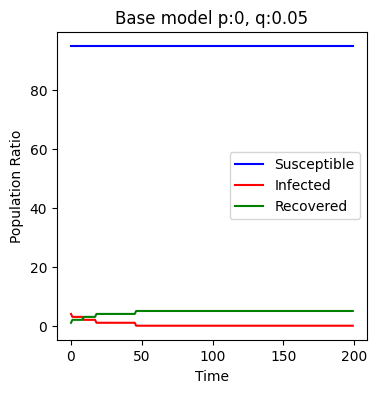

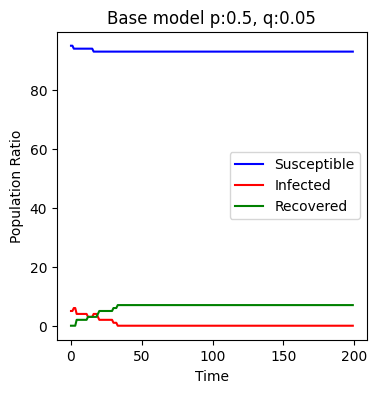

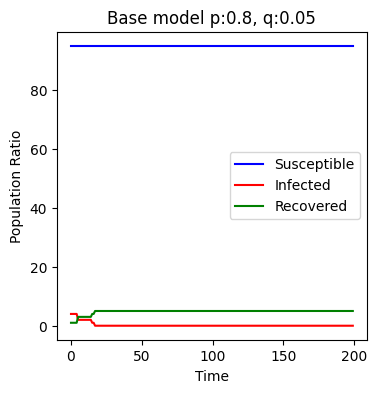

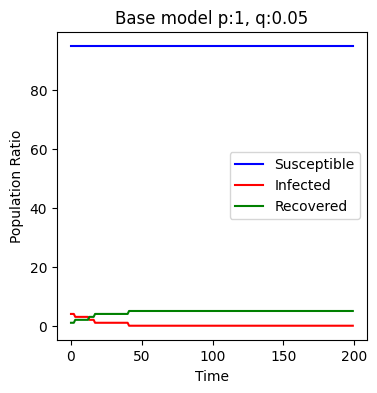

In [92]:
# No social distancing
run_trial(0,0.05)
run_trial(0.5,0.05)
run_trial(0.8,0.05)
_= run_trial(1,0.05)

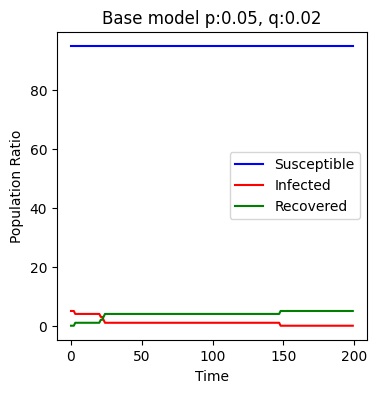

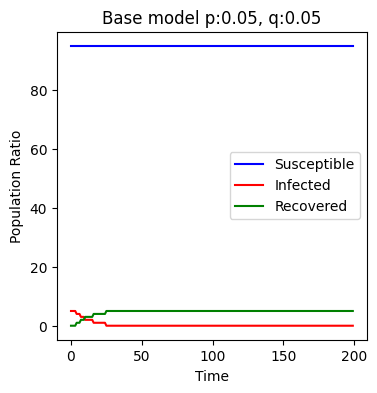

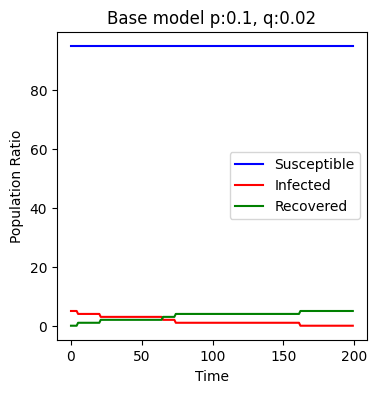

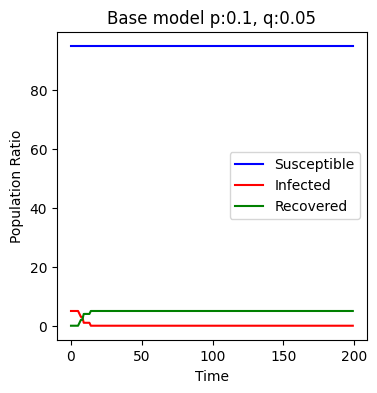

In [93]:
# NO SOCIAL DISTANCING
run_trial(0.05,0.02)
run_trial(0.05,0.05)
run_trial(0.1,0.02)
_= run_trial(0.1,0.05)


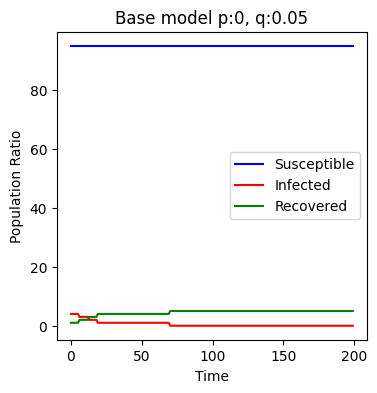

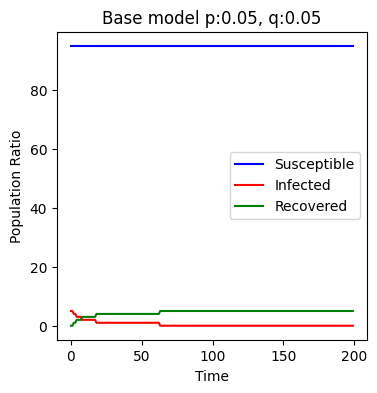

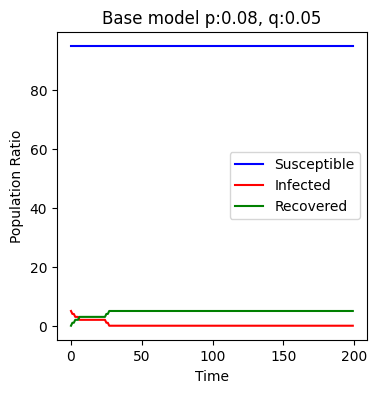

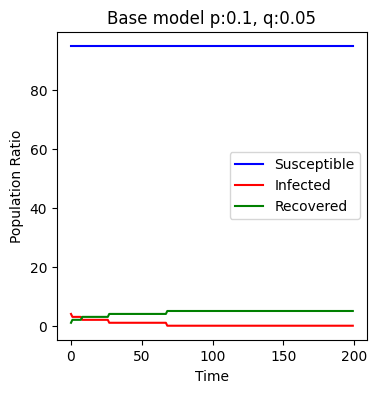

In [94]:
# No social distancing
run_trial(0,0.05)
run_trial(0.05,0.05)
run_trial(0.08,0.05)
_= run_trial(0.1,0.05)

### Rerun the simulation with other random initial conditions and average

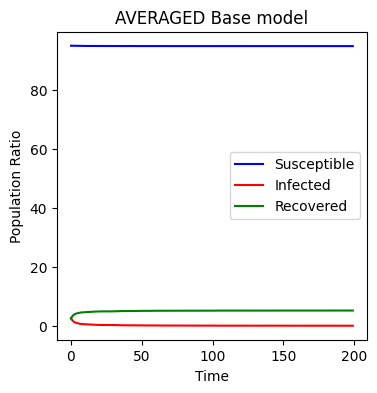

In [95]:
# No social distancing
p_s = np.random.ranf(100)
q_s = np.random.ranf(100)
trials = [(round(p_s[i],3), round(q_s[i],3)) for i in range(100)]
random_results = pd.DataFrame()
for p,q in trials:
    curr_r = run_trial(p, q, show_plot=False)
    random_results = pd.concat([random_results, curr_r])
average_random_results = random_results.groupby("Time").mean().reset_index()
plot_func(average_random_results, title="AVERAGED Base model")

#### Social Distancing

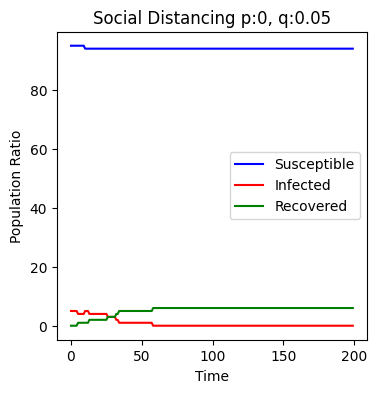

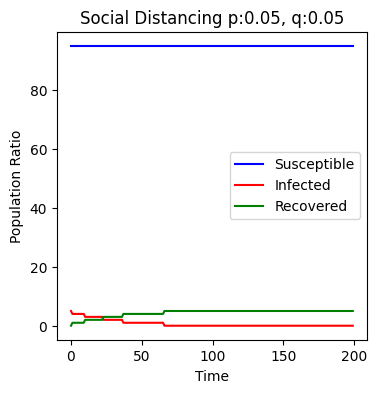

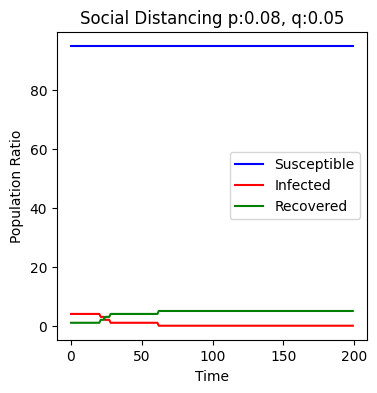

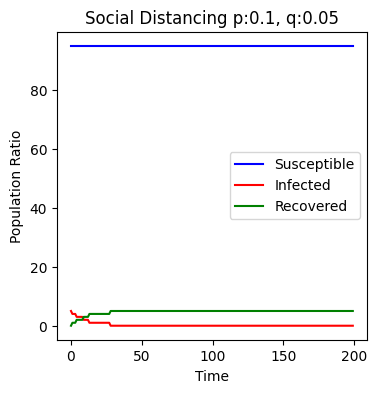

In [96]:
#Social distancing (i.e lower p of infection and  higher p(stay))
run_trial(0,0.05, social_distancing=True)
run_trial(0.05,0.05, social_distancing=True)
run_trial(0.08,0.05, social_distancing=True)
_= run_trial(0.1,0.05, social_distancing=True)


### Rerun extended model simulation with other random initial conditions and average

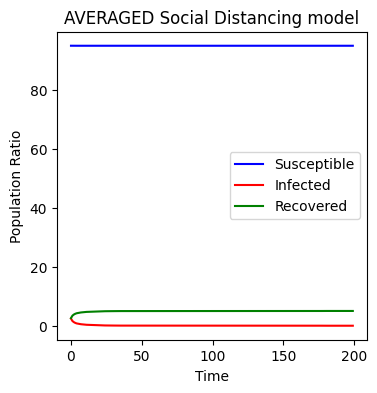

In [97]:
# With Social distancing
p_s = np.random.uniform(0.0, 0.2, size = 200)
q_s = np.random.ranf(100)
trials = [(round(p_s[i],3), round(q_s[i],3)) for i in range(100)]
random_results = pd.DataFrame()
for p,q in trials:
    curr_r = run_trial(p, q, social_distancing=True, show_plot=False)
    random_results = pd.concat([random_results, curr_r])
average_random_results = random_results.groupby("Time").mean().reset_index()
plot_func(average_random_results, title="AVERAGED Social Distancing model")

### Rerun social distancing with different probabilities of movement

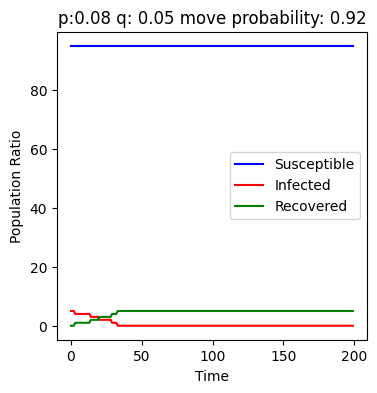

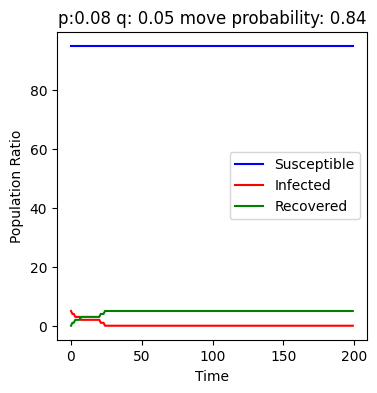

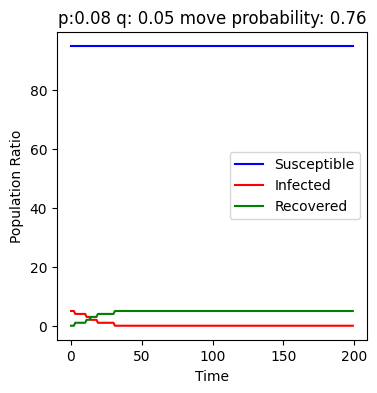

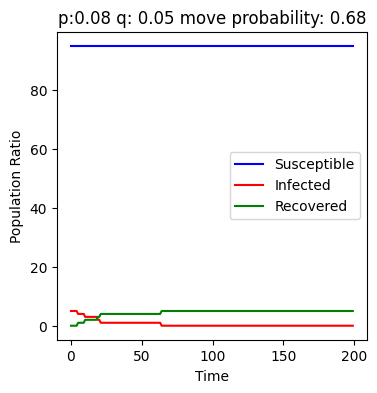

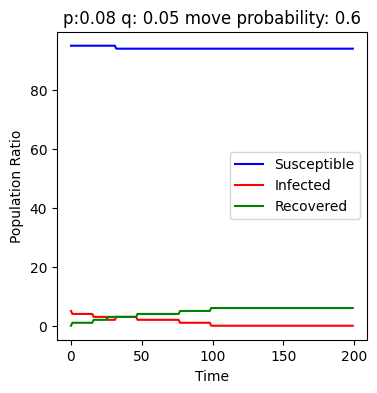

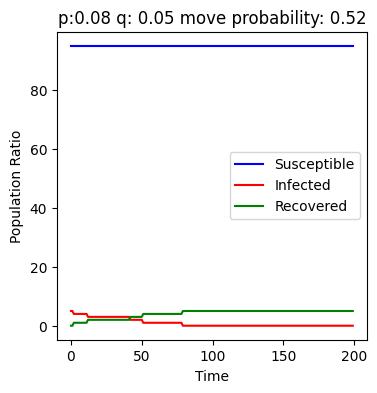

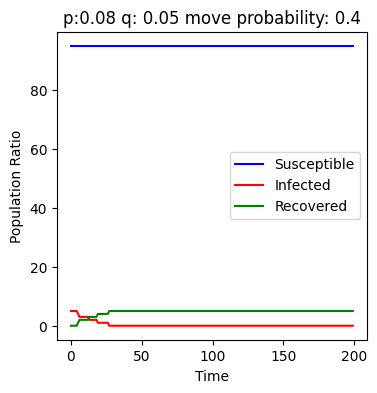

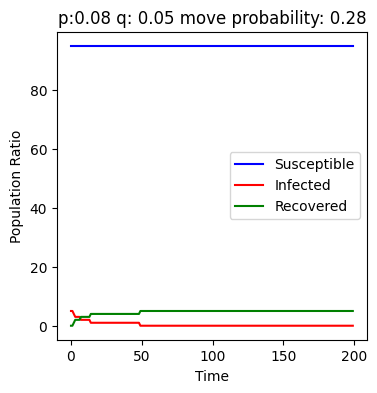

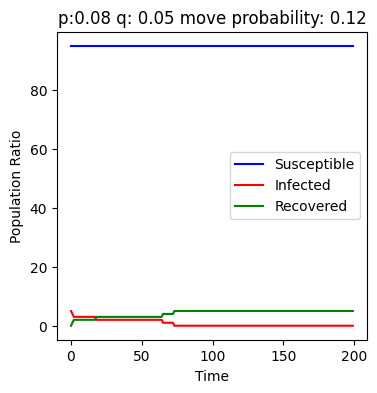

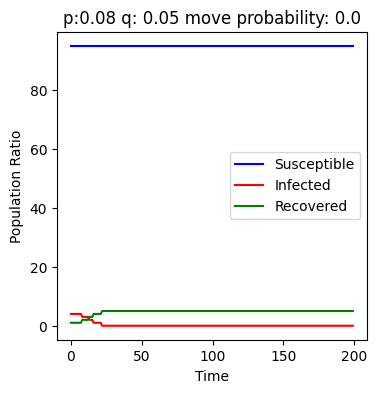

In [81]:
#Social distancing
trial_list = [
    [0.02, 0.02, 0.02, 0.02, 0.92],
    [0.04, 0.04, 0.04, 0.04, 0.84],
    [0.06, 0.06, 0.06, 0.06, 0.76],
    [0.08, 0.08, 0.08, 0.08, 0.68],
    [0.10, 0.10, 0.10, 0.10, 0.60],
    [0.12, 0.12, 0.12, 0.12, 0.52],
    [0.15, 0.15, 0.15, 0.15, 0.40],
    [0.18, 0.18, 0.18, 0.18, 0.28],
    [0.22, 0.22, 0.22, 0.22, 0.12],
    [0.25, 0.25, 0.25, 0.25, 0.00],
]
for t in trial_list:
    run_trial(p=0.08, q = 0.05, social_distancing=True, direction_choice_p=t)